<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/misc/BER_BLER_PyLDPC_CommPy_ITPP_LDPC_50_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

Cloning into 'CommPy'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 2107 (delta 5), reused 4 (delta 0), pack-reused 2090
Receiving objects: 100% (2107/2107), 1.42 MiB | 8.92 MiB/s, done.
Resolving deltas: 100% (1318/1318), done.


In [2]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

     |████████████████████████████████| 1.1MB 4.9MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=b3b8ccabedf572e2587632f72ad65eb2ef562c37eb5268ae4bd3a1acda7a3156
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc


In [3]:
import pyldpc
import numpy 
import time


In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later



In [5]:
plot_x_axis = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]

In [6]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [7]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 0 ... 1 1 0]
 [0 1 0 ... 0 1 0]]


In [9]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    diffc = abs(decoded_message-input_message[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,bler)
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 7.13s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 13.61s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 20.37s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 27.14s
SNR: 0.000:
 -> BLER: 0.642000 BER: 0.143778
 -> Total Time: 68.24s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.85s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.58s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 18.20s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 23.87s
SNR: 0.500:
 -> BLER: 0.583000 BER: 0.128222
 -> Total Time: 59.50s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 4.98s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 11.00s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 15.99s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.24s
SNR: 1.000:
 -> BLER: 0.504000 BER: 0.110222
 -> Total Time: 53.20s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.06s
SNR: 1.500 - Iter: 500 - Last 

In [10]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
ber_per_iter_pyldpc_commpy_psk_2  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_2= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_2=numpy.append(bler_per_iter_pyldpc_commpy_psk_2 ,bler)
  ber_per_iter_pyldpc_commpy_psk_2=numpy.append(ber_per_iter_pyldpc_commpy_psk_2 ,ber)
  times_per_iter_pyldpc_commpy_psk_2=numpy.append(times_per_iter_pyldpc_commpy_psk_2, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 6.44s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 13.03s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 19.56s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 25.88s
SNR: 0.000:
 ->BLER: 0.548000 BER: 0.094111
 -> Total Time: 64.91s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.61s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 11.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 17.57s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 23.88s
SNR: 0.500:
 ->BLER: 0.500000 BER: 0.086889
 -> Total Time: 58.56s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.29s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.49s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 15.80s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.22s
SNR: 1.000:
 ->BLER: 0.406000 BER: 0.066556
 -> Total Time: 52.80s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 4.64s
SNR: 1.500 - Iter: 500 - Last 250

In [11]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
ber_per_iter_pyldpc_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_pyldpc_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_commpy_psk_4 ,bler)
  ber_per_iter_pyldpc_commpy_psk_4=numpy.append(ber_per_iter_pyldpc_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_commpy_psk_4=numpy.append(times_per_iter_pyldpc_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 7.90s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 15.74s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 23.50s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 31.04s
SNR: 0.000:
 -> BLER: 0.796000 BER: 0.220556
 -> Total Time: 78.19s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 7.50s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 15.29s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 23.04s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 30.57s
SNR: 0.500:
 -> BLER: 0.788000 BER: 0.213333
 -> Total Time: 76.39s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 7.17s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 14.75s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 22.29s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 30.34s
SNR: 1.000:
 -> BLER: 0.755000 BER: 0.193111
 -> Total Time: 74.55s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 7.07s
SNR: 1.500 - Iter: 500 - Last 

In [12]:
num_parity_check = 5
num_bits_in_parity_check = 10
CHANEL_SIZE_50_100 = 100
ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE_50_100, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length_50_100 = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length_50_100, "channel_size=",CHANEL_SIZE_50_100)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length_50_100))
print (input_message)

input_message_size= 54 channel_size= 100
input_message_size= 54 channel_size= 100
[[0 1 1 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 1 0 ... 0 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]]


In [13]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc_50_100_commpy_psk_4  = numpy.array(())
ber_per_iter_pyldpc_50_100_commpy_psk_4  = numpy.array(())
times_per_iter_pyldpc_50_100_commpy_psk_4= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length_50_100)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_pyldpc_50_100_commpy_psk_4=numpy.append(bler_per_iter_pyldpc_50_100_commpy_psk_4 ,bler)
  ber_per_iter_pyldpc_50_100_commpy_psk_4=numpy.append(ber_per_iter_pyldpc_50_100_commpy_psk_4 ,ber)
  times_per_iter_pyldpc_50_100_commpy_psk_4=numpy.append(times_per_iter_pyldpc_50_100_commpy_psk_4, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 32.63s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 65.18s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 97.93s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 130.70s
SNR: 0.000:
 -> BLER: 1.000000 BER: 0.214111
 -> Total Time: 326.44s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 32.60s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 65.24s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 97.86s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 130.51s
SNR: 0.500:
 -> BLER: 0.999000 BER: 0.200963
 -> Total Time: 326.21s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 32.78s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 65.42s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 97.99s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 130.69s
SNR: 1.000:
 -> BLER: 1.000000 BER: 0.183463
 -> Total Time: 326.87s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 32.83s
SNR: 1.500 - Iter: 5

In [14]:
input_message_length = 9
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_2  = numpy.array(())
ber_per_iter_uncoded_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_uncoded_commpy_psk_2=numpy.append(bler_per_iter_uncoded_commpy_psk_2 ,bler)
  ber_per_iter_uncoded_commpy_psk_2=numpy.append(ber_per_iter_uncoded_commpy_psk_2 ,ber)
  times_per_iter_uncoded_commpy_psk_2=numpy.append(times_per_iter_uncoded_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BLER: 0.508000 BER: 0.079556
 -> Total Time: 0.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 0.500:
 -> BLER: 0.485000 BER: 0.070556
 -> Total Time: 0.33s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BLER: 0.401000 BER: 0.053444
 -> Total Time: 0.29s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [15]:
input_message_length = 50
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_commpy_psk_2  = numpy.array(())
ber_per_iter_uncoded_50_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_50_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_commpy_psk_2=numpy.append(bler_per_iter_uncoded_50_commpy_psk_2 ,bler)
  ber_per_iter_uncoded_50_commpy_psk_2=numpy.append(ber_per_iter_uncoded_50_commpy_psk_2 ,ber)
  times_per_iter_uncoded_50_commpy_psk_2=numpy.append(times_per_iter_uncoded_50_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.15s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.21s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.28s
SNR: 0.000:
 -> BLER: 0.984000 BER: 0.077820
 -> Total Time: 0.73s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.21s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.28s
SNR: 0.500:
 -> BLER: 0.977000 BER: 0.067120
 -> Total Time: 0.69s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.14s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.21s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.29s
SNR: 1.000:
 -> BLER: 0.951000 BER: 0.057140
 -> Total Time: 0.70s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.07s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [16]:
input_message_length = 100
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_2  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_2  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_2=numpy.append(bler_per_iter_uncoded_100_commpy_psk_2 ,bler)
  ber_per_iter_uncoded_100_commpy_psk_2=numpy.append(ber_per_iter_uncoded_100_commpy_psk_2 ,ber)
  times_per_iter_uncoded_100_commpy_psk_2=numpy.append(times_per_iter_uncoded_100_commpy_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.22s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.35s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.46s
SNR: 0.000:
 -> BLER: 1.000000 BER: 0.079210
 -> Total Time: 1.14s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.22s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.33s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.44s
SNR: 0.500:
 -> BLER: 0.999000 BER: 0.067130
 -> Total Time: 1.11s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.22s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.33s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.44s
SNR: 1.000:
 -> BLER: 0.995000 BER: 0.055250
 -> Total Time: 1.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.11s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [17]:
input_message_length = 10
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_uncoded_commpy_psk_4=numpy.append(bler_per_iter_uncoded_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_commpy_psk_4=numpy.append(ber_per_iter_uncoded_commpy_psk_4 ,ber)
  times_per_iter_uncoded_commpy_psk_4=numpy.append(times_per_iter_uncoded_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 0.000:
 -> BLER: 0.817000 BER: 0.213700
 -> Total Time: 0.31s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.500:
 -> BLER: 0.784000 BER: 0.194300
 -> Total Time: 0.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.12s
SNR: 1.000:
 -> BLER: 0.755000 BER: 0.177300
 -> Total Time: 0.31s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [18]:
input_message_length = 50
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_50_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_50_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_commpy_psk_4=numpy.append(bler_per_iter_uncoded_50_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_50_commpy_psk_4=numpy.append(ber_per_iter_uncoded_50_commpy_psk_4 ,ber)
  times_per_iter_uncoded_50_commpy_psk_4=numpy.append(times_per_iter_uncoded_50_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.17s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.22s
SNR: 0.000:
 ->BLER: 1.000000 BER: 0.213040
 -> Total Time: 0.55s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.17s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.22s
SNR: 0.500:
 ->BLER: 0.999000 BER: 0.194440
 -> Total Time: 0.56s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.11s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.17s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.22s
SNR: 1.000:
 ->BLER: 1.000000 BER: 0.181320
 -> Total Time: 0.56s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 1.500 - Iter: 500 - Last 250.0 iteration

In [19]:
input_message_length = 100
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_4=numpy.append(bler_per_iter_uncoded_100_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_100_commpy_psk_4=numpy.append(ber_per_iter_uncoded_100_commpy_psk_4 ,ber)
  times_per_iter_uncoded_100_commpy_psk_4=numpy.append(times_per_iter_uncoded_100_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.24s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.32s
SNR: 0.000:
 ->BLER: 1.000000 BER: 0.217330
 -> Total Time: 0.80s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.15s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.23s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.31s
SNR: 0.500:
 ->BLER: 1.000000 BER: 0.196280
 -> Total Time: 0.78s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.17s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.25s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.33s
SNR: 1.000:
 ->BLER: 1.000000 BER: 0.178770
 -> Total Time: 0.82s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 1.500 - Iter: 500 - Last 250.0 iteration

In [20]:
input_message_length = 100
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(4)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_commpy_psk_4  = numpy.array(())
times_per_iter_uncoded_100_commpy_psk_4 = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_commpy_psk_4=numpy.append(bler_per_iter_uncoded_100_commpy_psk_4 ,bler)
  ber_per_iter_uncoded_100_commpy_psk_4=numpy.append(ber_per_iter_uncoded_100_commpy_psk_4 ,ber)
  times_per_iter_uncoded_100_commpy_psk_4=numpy.append(times_per_iter_uncoded_100_commpy_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.24s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.33s
SNR: 0.000:
 ->BLER: 1.000000 BER: 0.211120
 -> Total Time: 0.81s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.17s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.34s
SNR: 0.500:
 ->BLER: 1.000000 BER: 0.195910
 -> Total Time: 0.84s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.24s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.32s
SNR: 1.000:
 ->BLER: 1.000000 BER: 0.181000
 -> Total Time: 0.81s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 500 - Last 250.0 iteration

In [21]:
input_message_length = 9 
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))

modem = mod.PSKModem(8)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_commpy_psk_8  = numpy.array(())
ber_per_iter_uncoded_commpy_psk_8  = numpy.array(())
times_per_iter_uncoded_commpy_psk_8 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    diffc = abs(decoded_message-input_message_uncoded[i]).sum ()
    if diffc != 0 :
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n ->BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_commpy_psk_8=numpy.append(bler_per_iter_uncoded_commpy_psk_8 ,bler)
  ber_per_iter_uncoded_commpy_psk_8=numpy.append(ber_per_iter_uncoded_commpy_psk_8 ,ber)
  times_per_iter_uncoded_commpy_psk_8=numpy.append(times_per_iter_uncoded_commpy_psk_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.000:
 ->BLER: 0.923000 BER: 0.325778
 -> Total Time: 0.28s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.500:
 ->BLER: 0.912000 BER: 0.315333
 -> Total Time: 0.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 1.000:
 ->BLER: 0.891000 BER: 0.304556
 -> Total Time: 0.27s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iteration

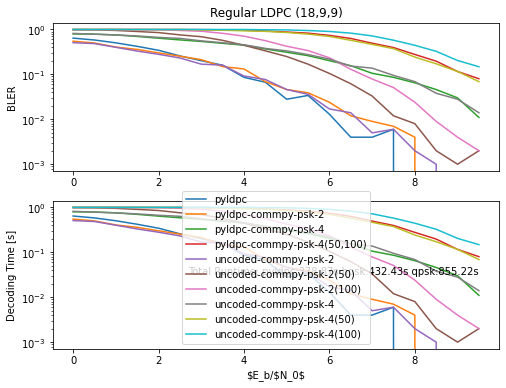

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

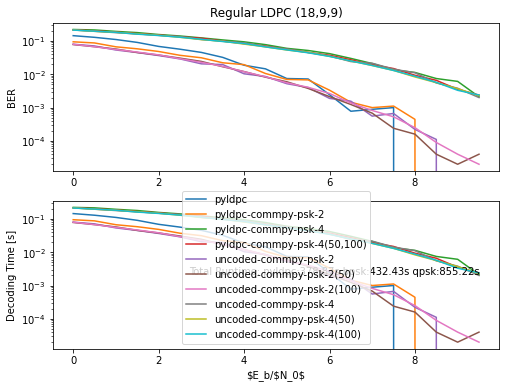

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_pyldpc_50_100_commpy_psk_4,'', label="pyldpc-commpy-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

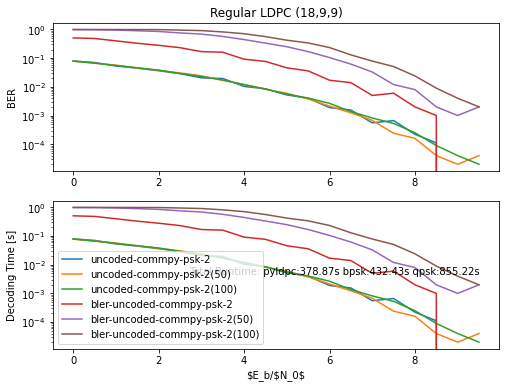

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(100)") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="bler-uncoded-commpy-psk-2(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

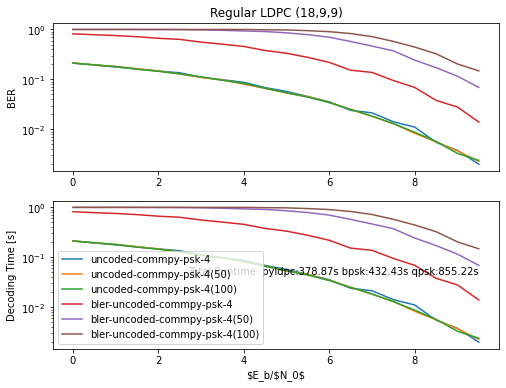

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(100)") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4,'', label="uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4,'', label="uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4,'', label="bler-uncoded-commpy-psk-4(100)") # plot BER vs SNR
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_pyldpc_commpy_psk_2), numpy.sum(times_per_iter_pyldpc_commpy_psk_4)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [26]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/iamviji/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 autoconf all 2.69-11 [322 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 automake all 1:1.15.1-3ubuntu2 [509 kB]
Fet

In [27]:
import pyitpp as itpp
from matplotlib import pyplot as plt

In [28]:
def cout_one_in_itpp_vec (one):
  count = 0
  for i in range (0, one.length()):
    if (ord(one[i].value()) == 1):
      count = count + 1
  return count

In [29]:
input_message_length = nrof_bits = 9
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_2  = numpy.array(())
ber_per_iter_uncoded_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, .5):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_2=numpy.append(bler_per_iter_uncoded_itpp_psk_2 ,bler)
  ber_per_iter_uncoded_itpp_psk_2=numpy.append(ber_per_iter_uncoded_itpp_psk_2 ,ber)
  times_per_iter_uncoded_itpp_psk_2=numpy.append(times_per_iter_uncoded_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BLER: 0.518000 BER: 0.079333
 -> Total Time: 0.10s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.478000 BER: 0.067000
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.415000 BER: 0.058000
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [30]:
input_message_length = nrof_bits = 9
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_bpsk  = numpy.array(())
ber_per_iter_uncoded_itpp_bpsk  = numpy.array(())
times_per_iter_uncoded_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_bpsk=numpy.append(bler_per_iter_uncoded_itpp_bpsk ,bler)
  ber_per_iter_uncoded_itpp_bpsk=numpy.append(ber_per_iter_uncoded_itpp_bpsk ,ber)
  times_per_iter_uncoded_itpp_bpsk=numpy.append(times_per_iter_uncoded_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BLER: 0.774000 BER: 0.157778
 -> Total Time: 0.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.769000 BER: 0.139667
 -> Total Time: 0.07s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.731000 BER: 0.129556
 -> Total Time: 0.08s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [31]:
input_message_length = nrof_bits = 10
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_4  = numpy.array(())
ber_per_iter_uncoded_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_4=numpy.append(bler_per_iter_uncoded_itpp_psk_4 ,bler)
  ber_per_iter_uncoded_itpp_psk_4=numpy.append(ber_per_iter_uncoded_itpp_psk_4 ,ber)
  times_per_iter_uncoded_itpp_psk_4=numpy.append(times_per_iter_uncoded_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BLER: 0.814000 BER: 0.155900
 -> Total Time: 0.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.767000 BER: 0.142100
 -> Total Time: 0.07s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.729000 BER: 0.124800
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [32]:
input_message_length = nrof_bits = 100
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_itpp_psk_4  = numpy.array(())
ber_per_iter_uncoded_100_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_100_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_itpp_psk_4=numpy.append(bler_per_iter_uncoded_100_itpp_psk_4 ,bler)
  ber_per_iter_uncoded_100_itpp_psk_4=numpy.append(ber_per_iter_uncoded_100_itpp_psk_4 ,ber)
  times_per_iter_uncoded_100_itpp_psk_4=numpy.append(times_per_iter_uncoded_100_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 0.000:
 -> BLER: 1.000000 BER: 0.159650
 -> Total Time: 0.49s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BLER: 1.000000 BER: 0.143970
 -> Total Time: 0.43s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 1.000:
 -> BLER: 1.000000 BER: 0.133280
 -> Total Time: 0.48s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [33]:
input_message_length = nrof_bits = 50
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_itpp_psk_4  = numpy.array(())
ber_per_iter_uncoded_50_itpp_psk_4  = numpy.array(())
times_per_iter_uncoded_50_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_itpp_psk_4=numpy.append(bler_per_iter_uncoded_50_itpp_psk_4 ,bler)
  ber_per_iter_uncoded_50_itpp_psk_4=numpy.append(ber_per_iter_uncoded_50_itpp_psk_4 ,ber)
  times_per_iter_uncoded_50_itpp_psk_4=numpy.append(times_per_iter_uncoded_50_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.000:
 -> BLER: 1.000000 BER: 0.158220
 -> Total Time: 0.27s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.07s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.09s
SNR: 0.500:
 -> BLER: 0.999000 BER: 0.145760
 -> Total Time: 0.24s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.10s
SNR: 1.000:
 -> BLER: 1.000000 BER: 0.132200
 -> Total Time: 0.24s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [34]:
input_message_length = nrof_bits = 50
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_50_itpp_psk_2  = numpy.array(())
ber_per_iter_uncoded_50_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_50_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_50_itpp_psk_2=numpy.append(bler_per_iter_uncoded_50_itpp_psk_2 ,bler)
  ber_per_iter_uncoded_50_itpp_psk_2=numpy.append(ber_per_iter_uncoded_50_itpp_psk_2 ,ber)
  times_per_iter_uncoded_50_itpp_psk_2=numpy.append(times_per_iter_uncoded_50_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.06s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.000:
 -> BLER: 0.978000 BER: 0.079720
 -> Total Time: 0.28s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 0.500:
 -> BLER: 0.964000 BER: 0.068220
 -> Total Time: 0.28s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.11s
SNR: 1.000:
 -> BLER: 0.941000 BER: 0.056340
 -> Total Time: 0.27s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [35]:
input_message_length = nrof_bits = 100
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_100_itpp_psk_2  = numpy.array(())
ber_per_iter_uncoded_100_itpp_psk_2  = numpy.array(())
times_per_iter_uncoded_100_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_100_itpp_psk_2=numpy.append(bler_per_iter_uncoded_100_itpp_psk_2 ,bler)
  ber_per_iter_uncoded_100_itpp_psk_2=numpy.append(ber_per_iter_uncoded_100_itpp_psk_2 ,ber)
  times_per_iter_uncoded_100_itpp_psk_2=numpy.append(times_per_iter_uncoded_100_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 0.000:
 -> BLER: 0.999000 BER: 0.078630
 -> Total Time: 0.50s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 0.500:
 -> BLER: 0.999000 BER: 0.067680
 -> Total Time: 0.50s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 1.000:
 -> BLER: 0.997000 BER: 0.056830
 -> Total Time: 0.50s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [36]:
print (bler_per_iter_uncoded_100_itpp_psk_4)
print (bler_per_iter_uncoded_50_itpp_psk_2)
print (bler_per_iter_uncoded_100_itpp_psk_2)
print (ber_per_iter_uncoded_100_itpp_psk_4)
print (ber_per_iter_uncoded_50_itpp_psk_2)
print (ber_per_iter_uncoded_100_itpp_psk_2)

[1.    1.    1.    1.    1.    1.    1.    0.998 0.999 0.992 0.986 0.955
 0.904 0.834 0.69  0.606 0.464 0.305 0.209 0.138]
[0.978 0.964 0.941 0.908 0.85  0.753 0.697 0.59  0.484 0.36  0.276 0.178
 0.115 0.064 0.047 0.019 0.006 0.002 0.001 0.   ]
[0.999 0.999 0.997 0.992 0.976 0.945 0.904 0.824 0.703 0.609 0.429 0.329
 0.225 0.131 0.079 0.042 0.013 0.005 0.003 0.   ]
[0.15965 0.14397 0.13328 0.11527 0.10492 0.09096 0.07876 0.06758 0.0574
 0.04708 0.03793 0.03001 0.02311 0.01739 0.01257 0.00896 0.00626 0.00369
 0.00229 0.00153]
[7.972e-02 6.822e-02 5.634e-02 4.596e-02 3.966e-02 2.886e-02 2.342e-02
 1.748e-02 1.260e-02 8.960e-03 6.480e-03 3.720e-03 2.480e-03 1.320e-03
 9.400e-04 3.800e-04 1.200e-04 4.000e-05 2.000e-05 0.000e+00]
[7.863e-02 6.768e-02 5.683e-02 4.818e-02 3.725e-02 2.978e-02 2.401e-02
 1.706e-02 1.257e-02 9.310e-03 5.710e-03 3.890e-03 2.590e-03 1.410e-03
 8.300e-04 4.300e-04 1.300e-04 5.000e-05 3.000e-05 0.000e+00]


In [37]:
input_message_length = nrof_bits = 9
modulator = itpp.comm.PSK(8)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded_itpp_psk_8  = numpy.array(())
ber_per_iter_uncoded_itpp_psk_8  = numpy.array(())
times_per_iter_uncoded_itpp_psk_8 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    tx_signal = modulator.modulate_bits(source_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    diffc = cout_one_in_itpp_vec (demodulated_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,ber,total_time))
  bler_per_iter_uncoded_itpp_psk_8=numpy.append(bler_per_iter_uncoded_itpp_psk_8 ,bler)
  ber_per_iter_uncoded_itpp_psk_8=numpy.append(ber_per_iter_uncoded_itpp_psk_8 ,ber)
  times_per_iter_uncoded_itpp_psk_8=numpy.append(bler_per_iter_uncoded_itpp_psk_8, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.000:
 -> BLER: 0.921000 BER: 0.245667
 -> Total Time: 0.08s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 0.500:
 -> BLER: 0.917000 BER: 0.234111
 -> Total Time: 0.08s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.03s
SNR: 1.000:
 -> BLER: 0.912000 BER: 0.214556
 -> Total Time: 0.09s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

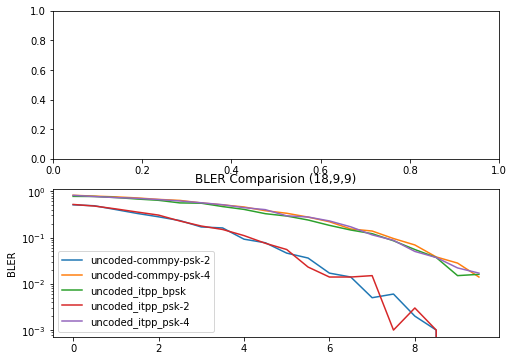

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

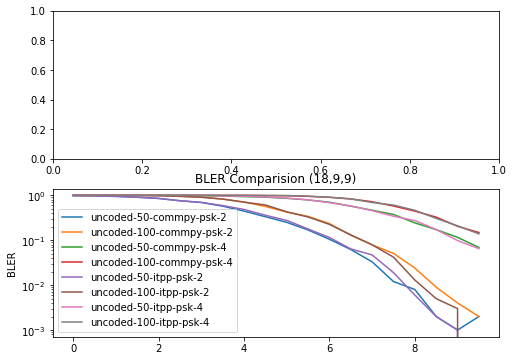

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-50-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-100-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_commpy_psk_4 ,'', label="uncoded-50-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_commpy_psk_4 ,'', label="uncoded-100-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_2,'', label="uncoded-50-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2 ,'', label="uncoded-100-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_4 ,'', label="uncoded-50-itpp-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_4 ,'', label="uncoded-100-itpp-psk-4") # plot BER vs SNR

ax2.set_ylabel('BLER')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

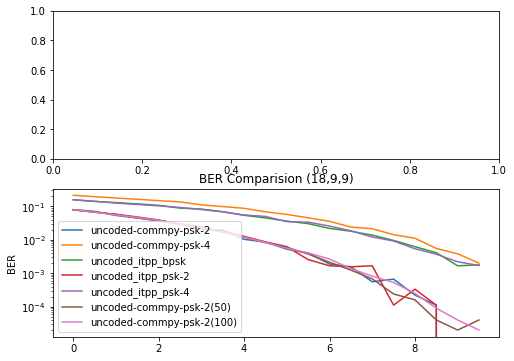

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_2 ,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)")
ax2.set_ylabel('BER')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

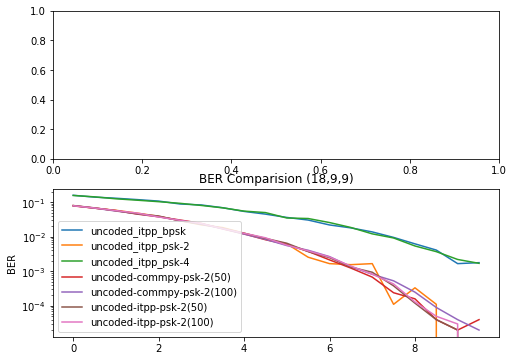

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_bpsk,'', label="uncoded_itpp_bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_2 ,'', label="uncoded-commpy-psk-2(100)")
ax2.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_2 ,'', label="uncoded-itpp-psk-2(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_2 ,'', label="uncoded-itpp-psk-2(100)")
ax2.set_ylabel('BER')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

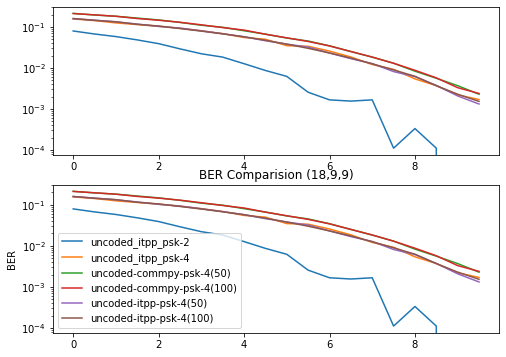

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))

ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(50)")
ax1.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(100)")
ax1.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(50)")
ax1.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(100)")


ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="uncoded_itpp_psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_50_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_commpy_psk_4 ,'', label="uncoded-commpy-psk-4(100)")
ax2.semilogy(snrs,ber_per_iter_uncoded_50_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(50)")
ax2.semilogy(snrs,ber_per_iter_uncoded_100_itpp_psk_4 ,'', label="uncoded-itpp-psk-4(100)")

ax2.set_ylabel('BER')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [43]:
input_message_length = nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.BPSK()
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_bpsk  = numpy.array(())
ber_per_iter_ham_itpp_bpsk  = numpy.array(())
times_per_iter_ham_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_itpp_bpsk=numpy.append(bler_per_iter_ham_itpp_bpsk ,bler)
  ber_per_iter_ham_itpp_bpsk=numpy.append(ber_per_iter_ham_itpp_bpsk ,ber)
  times_per_iter_ham_itpp_bpsk=numpy.append(times_per_iter_ham_itpp_bpsk, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.000:
 -> BLER: 0.537000 BER: 0.143375
 -> Total Time: 0.11s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 0.500:
 -> BLER: 0.402000 BER: 0.105750
 -> Total Time: 0.10s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BLER: 0.397000 BER: 0.103250
 -> Total Time: 0.11s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [44]:
input_message_length = nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_2  = numpy.array(())
ber_per_iter_ham_itpp_psk_2  = numpy.array(())
times_per_iter_ham_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_itpp_psk_2=numpy.append(bler_per_iter_ham_itpp_psk_2 ,bler)
  ber_per_iter_ham_itpp_psk_2=numpy.append(ber_per_iter_ham_itpp_psk_2 ,ber)
  times_per_iter_ham_itpp_psk_2=numpy.append(times_per_iter_ham_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.06s
SNR: 0.000:
 -> BLER: 0.177000 BER: 0.043125
 -> Total Time: 0.15s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.02s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.06s
SNR: 0.500:
 -> BLER: 0.138000 BER: 0.031125
 -> Total Time: 0.15s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 1.000:
 -> BLER: 0.095000 BER: 0.022250
 -> Total Time: 0.11s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [45]:
input_message_length = nrof_bits = 8 #Hamming(7,4,3) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_itpp_psk_4  = numpy.array(())
ber_per_iter_ham_itpp_psk_4  = numpy.array(())
times_per_iter_ham_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    #print ("x")
    #print (source_bits)
    encoded_bits = hamm.encode(source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_itpp_psk_4=numpy.append(bler_per_iter_ham_itpp_psk_4 ,bler)
  ber_per_iter_ham_itpp_psk_4=numpy.append(ber_per_iter_ham_itpp_psk_4 ,ber)
  times_per_iter_ham_itpp_psk_4=numpy.append(times_per_iter_ham_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 0.000:
 -> BLER: 0.532000 BER: 0.141375
 -> Total Time: 0.13s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.03s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.05s
SNR: 0.500:
 -> BLER: 0.466000 BER: 0.124500
 -> Total Time: 0.13s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.02s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.04s
SNR: 1.000:
 -> BLER: 0.382000 BER: 0.096125
 -> Total Time: 0.11s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.01s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [46]:
input_message_length = nrof_bits = 64 #Hamming(63,57,6) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_50_itpp_psk_2  = numpy.array(())
ber_per_iter_ham_50_itpp_psk_2  = numpy.array(())
times_per_iter_ham_50_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_50_itpp_psk_2=numpy.append(bler_per_iter_ham_50_itpp_psk_2 ,bler)
  ber_per_iter_ham_50_itpp_psk_2=numpy.append(ber_per_iter_ham_50_itpp_psk_2 ,ber)
  times_per_iter_ham_50_itpp_psk_2=numpy.append(times_per_iter_ham_50_itpp_psk_2, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.16s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.21s
SNR: 0.000:
 -> BLER: 0.787000 BER: 0.043656
 -> Total Time: 0.53s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.06s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.12s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.17s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.22s
SNR: 0.500:
 -> BLER: 0.713000 BER: 0.033172
 -> Total Time: 0.58s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.21s
SNR: 1.000:
 -> BLER: 0.602000 BER: 0.024219
 -> Total Time: 0.53s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [47]:
input_message_length = nrof_bits = 64 #Hamming(63,57,6) But x2
hamm = itpp.comm.Hamming_Code(3)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ham_50_itpp_psk_4  = numpy.array(())
ber_per_iter_ham_50_itpp_psk_4  = numpy.array(())
times_per_iter_ham_50_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = hamm.encode(source_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    decoded_bits = hamm.decode(demodulated_bits) 
    #print (source_bits)
    #print (decoded_bits)
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_ham_50_itpp_psk_4=numpy.append(bler_per_iter_ham_50_itpp_psk_4 ,bler)
  ber_per_iter_ham_50_itpp_psk_4=numpy.append(ber_per_iter_ham_50_itpp_psk_4 ,ber)
  times_per_iter_ham_50_itpp_psk_4=numpy.append(times_per_iter_ham_50_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.15s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 0.000:
 -> BLER: 0.991000 BER: 0.142359
 -> Total Time: 0.50s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 0.500:
 -> BLER: 0.995000 BER: 0.123438
 -> Total Time: 0.47s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.19s
SNR: 1.000:
 -> BLER: 0.988000 BER: 0.106500
 -> Total Time: 0.48s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.05s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [48]:
print ("bler_per_iter_ham_itpp_psk_4=",bler_per_iter_ham_itpp_psk_4)

bler_per_iter_ham_itpp_psk_4= [0.532 0.466 0.382 0.371 0.3   0.224 0.179 0.171 0.107 0.078 0.055 0.032
 0.025 0.011 0.003 0.002 0.001 0.    0.    0.   ]


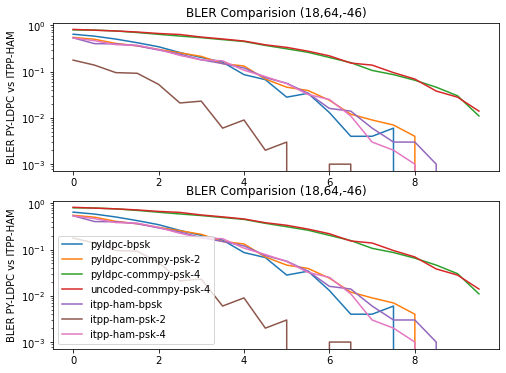

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

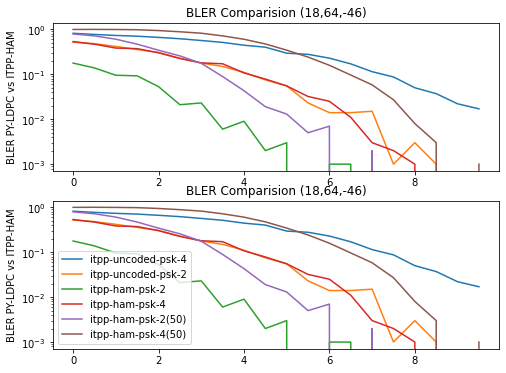

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

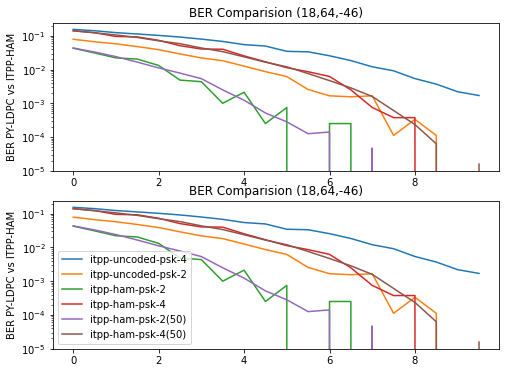

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax1.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_uncoded_itpp_psk_2,'', label="itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

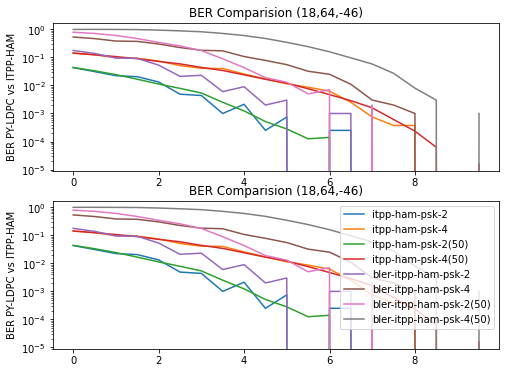

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="bler-itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="bler-itpp-ham-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR

ax1.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax1.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_2,'', label="itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,ber_per_iter_ham_50_itpp_psk_4,'', label="itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="bler-itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_2,'', label="bler-itpp-ham-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR

ax2.set_ylabel('BER PY-LDPC vs ITPP-HAM')
ax2.set_title('BER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [53]:
input_message_length = nrof_bits =14
bch = itpp.comm.bch(15, 2, False)
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_bch_itpp_psk_4  = numpy.array(())
ber_per_iter_bch_itpp_psk_4  = numpy.array(())
times_per_iter_bch_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = itpp.base.bvec ()
    #print ("x")
    #print (source_bits)
    bch.encode(source_bits, encoded_bits)
    #prinrt (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    #print (demodulated_bits)
    decoded_bits = itpp.base.bvec ()
    bch.decode(demodulated_bits, decoded_bits) 
    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    #if abs(demodulated_bits != source_bits):
    if diffc != 0: 
      total_msg_error = total_msg_error + 1
      total_bit_error = total_bit_error + diffc
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    #b = itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0)
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = float(total_bit_error)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,total_time))
  bler_per_iter_bch_itpp_psk_4=numpy.append(bler_per_iter_bch_itpp_psk_4 ,bler)
  ber_per_iter_bch_itpp_psk_4=numpy.append(ber_per_iter_bch_itpp_psk_4 ,ber)
  times_per_iter_bch_itpp_psk_4=numpy.append(times_per_iter_bch_itpp_psk_4, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.000:
 -> BLER: 0.670000 BER: 0.195071
 -> Total Time: 0.40s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BLER: 0.610000 BER: 0.179000
 -> Total Time: 0.41s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 1.000:
 -> BLER: 0.547000 BER: 0.142571
 -> Total Time: 0.40s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterat

In [54]:
options =itpp.ivec("18 9")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
input_message_length = nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(2)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_2  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_2  = numpy.array(())
times_per_iter_ldpc_itpp_psk_2 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_bit_error1 = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1

    diffc = cout_one_in_itpp_vec (decoded_bits -  source_bits)
    if diffc != 0: 
      total_bit_error1 = total_bit_error1 + diffc

    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber1 = total_bit_error / total_bit
  ber = float(total_bit_error1)/(NUM_OF_INPUT_MESSAGE*input_message_length)
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} BER: {:03.6f} {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler, ber,ber1,total_time))
  bler_per_iter_ldpc_itpp_psk_2=numpy.append(bler_per_iter_ldpc_itpp_psk_2 ,bler)
  ber_per_iter_ldpc_itpp_psk_2=numpy.append(ber_per_iter_ldpc_itpp_psk_2 ,ber)
  times_per_iter_ldpc_itpp_psk_2=numpy.append(times_per_iter_ldpc_itpp_psk_2, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.09s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.14s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.20s
SNR: 0.000:
 -> BLER: 0.084000 BER: 0.017444 0.017444
 -> Total Time: 0.48s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BLER: 0.063000 BER: 0.014000 0.014000
 -> Total Time: 0.42s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.07s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.10s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.13s
SNR: 1.000:
 -> BLER: 0.030000 BER: 0.006333 0.006333
 -> Total Time: 0.33s
SNR: 1.500 - Iter: 250 - Last 250.0 itera

In [55]:
options =itpp.ivec("36 12")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (100, 5, 10, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_50_100_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_50_100_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_50_100_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_msg_error1 = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
    blerc = itpp.comm.BLERC(nrof_bits)
    blerc.count(decoded_bits, source_bits)
    total_msg_error1 = total_msg_error1 + blerc.get_errorrate()
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  bler1 =  float(total_msg_error1)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BLER: {:03.6f} {:03.6f} BER: {:03.6f}\n -> Total Time: {:03.2f}s'.format(snr,bler,bler1, ber,total_time))
  ber_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(ber_per_iter_ldpc_50_100_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(bler_per_iter_ldpc_50_100_itpp_psk_4 ,bler)
  times_per_iter_ldpc_50_100_itpp_psk_4=numpy.append(times_per_iter_ldpc_50_100_itpp_psk_4, total_time)

nrof_bits= 50 nvar= 100 ncheck= 50
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 3.76s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 7.52s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 11.28s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 15.03s
SNR: 0.000:
 -> BLER: 1.000000 1.000000 BER: 0.159340
 -> Total Time: 37.59s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 3.74s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 7.50s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 11.24s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 14.99s
SNR: 0.500:
 -> BLER: 1.000000 1.000000 BER: 0.140560
 -> Total Time: 37.47s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.76s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.51s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.26s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 15.00s
SNR: 1.000:
 -> BLER: 0.999000 0.999000 BER: 0.125080
 -> Total Time: 37.53s
SNR: 1.500 - Iter: 250 - Last

In [56]:
print (bler_per_iter_ldpc_50_100_itpp_psk_4)
print (ber_per_iter_ldpc_50_100_itpp_psk_4)


[1.    1.    0.999 0.988 0.929 0.688 0.369 0.16  0.036 0.012 0.002 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[1.5934e-01 1.4056e-01 1.2508e-01 1.1166e-01 9.0340e-02 5.8760e-02
 2.9380e-02 1.4040e-02 3.4600e-03 1.3000e-03 1.4000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]


In [57]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_psk_4  = numpy.array(())
ber_per_iter_ldpc_itpp_psk_4  = numpy.array(())
times_per_iter_ldpc_itpp_psk_4 = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_psk_4=numpy.append(ber_per_iter_ldpc_itpp_psk_4 ,ber)
  bler_per_iter_ldpc_itpp_psk_4=numpy.append(bler_per_iter_ldpc_itpp_psk_4 ,bler)
  times_per_iter_ldpc_itpp_psk_4=numpy.append(times_per_iter_ldpc_itpp_psk_4, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.24s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.45s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.68s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.90s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 2.26s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.22s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.43s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.65s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.85s
SNR: 0.500:
 -> BER: 0.59
 -> Total Time: 2.15s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.18s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.36s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.53s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.73s
SNR: 1.000:
 -> BER: 0.47
 -> Total Time: 1.80s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.15s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.30s
SNR: 1.50

In [58]:
print ("bler_per_iter_ldpc_itpp_psk_4=", bler_per_iter_ldpc_itpp_psk_4)

bler_per_iter_ldpc_itpp_psk_4= [0.62  0.588 0.466 0.364 0.271 0.195 0.117 0.069 0.051 0.008 0.013 0.
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]


In [59]:
options =itpp.ivec("18 6")
ind =itpp.ivec("")
ldpc_parity_reg = itpp.comm.ldpc_parity_regular (18, 3, 6, 'rand', options)
ldpc_gen_sym = itpp.comm.ldpc_gen_systematic (ldpc_parity_reg, False, ind)
ldpc_code = itpp.comm.ldpc_code (ldpc_parity_reg, ldpc_gen_sym, False)
nrof_bits = ldpc_code.get_nvar ()  - ldpc_code.get_ncheck ()
print ("nrof_bits=", nrof_bits, "nvar=", ldpc_code.get_nvar (), "ncheck=",ldpc_code.get_ncheck ())
modulator = itpp.comm.PSK(4)
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_ldpc_itpp_bpsk  = numpy.array(())
ber_per_iter_ldpc_itpp_bpsk  = numpy.array(())
times_per_iter_ldpc_itpp_bpsk = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  total_bit = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    source_bits = itpp.base.randb(nrof_bits)
    encoded_bits = ldpc_code.encode(source_bits)
    #print ("x")
    #print (source_bits)
    #print (encoded_bits)
    tx_signal = modulator.modulate_bits(encoded_bits)
    noise_variance = 10 ** (-(snr) * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)
    rx_signal = channel(tx_signal)
    #demodulated_bits = modulator.demodulate_bits(rx_signal)
    demodulated_soft_bits = modulator.demodulate_soft_bits(rx_signal, noise_variance / ldpc_code.get_rate(), itpp.comm.Soft_Method.LOGMAP)
    #print (demodulated_soft_bits)
    decoded_soft_bits = ldpc_code.decode_soft_out(demodulated_soft_bits)
    decoded_bits = ldpc_code.decode(decoded_soft_bits)
    #print (decoded_bits)
    if abs(decoded_bits != source_bits):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
    total_bit_error = total_bit_error + itpp.comm.BERC.count_errors(source_bits, decoded_bits, 0, 0, 0)
    total_bit = total_bit + nrof_bits
    #print (b)
  bler = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  ber = total_bit_error / total_bit
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,bler,total_time))
  ber_per_iter_ldpc_itpp_bpsk=numpy.append(ber_per_iter_ldpc_itpp_bpsk ,ber)
  bler_per_iter_ldpc_itpp_bpsk=numpy.append(bler_per_iter_ldpc_itpp_bpsk ,bler)
  times_per_iter_ldpc_itpp_bpsk=numpy.append(times_per_iter_ldpc_itpp_bpsk, total_time)

nrof_bits= 9 nvar= 18 ncheck= 9
SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.22s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.42s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.63s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.84s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 2.11s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.18s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.36s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.54s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.72s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 1.81s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.16s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.31s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.46s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.63s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 1.57s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.12s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.24s
SNR: 1.50

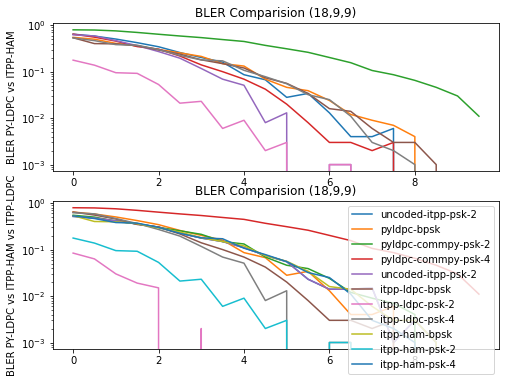

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded-itpp-psk-2") # plot BER vs SNR

ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded-itpp-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_ldpc_180_itpp_psk_4,'', label="uncoded-itpp-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [61]:
print (bler_per_iter_ldpc_itpp_psk_4)
print (bler_per_iter_uncoded_itpp_psk_2)
print (bler_per_iter_uncoded_itpp_psk_4)

[0.62  0.588 0.466 0.364 0.271 0.195 0.117 0.069 0.051 0.008 0.013 0.
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
[0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
[0.814 0.767 0.729 0.702 0.66  0.616 0.563 0.511 0.442 0.4   0.294 0.277
 0.228 0.17  0.114 0.087 0.05  0.037 0.022 0.017]


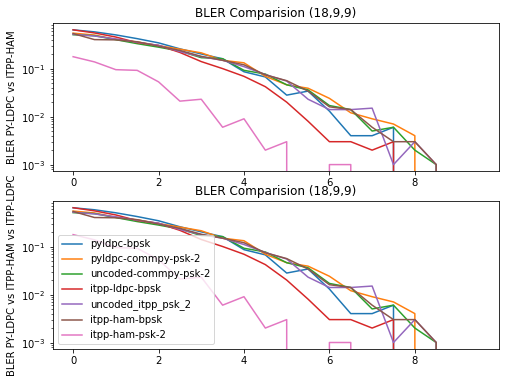

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk_2") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_2,'', label="pyldpc-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="uncoded-commpy-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="uncoded_itpp_psk_2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_2,'', label="itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_2,'', label="itpp-ham-psk-2") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

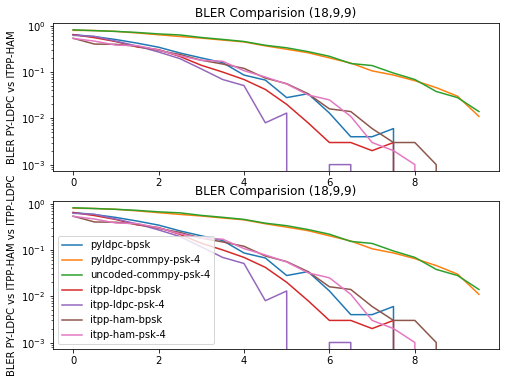

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER PY-LDPC vs ITPP-HAM')
ax1.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_pyldpc_commpy_psk_4,'', label="pyldpc-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="uncoded-commpy-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_bpsk,'', label="itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_bpsk,'', label="itpp-ham-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham-psk-4") # plot BER vs SNR
ax2.set_ylabel('BLER PY-LDPC vs ITPP-HAM vs ITPP-LDPC')
ax2.set_title('BLER Comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [64]:
import numpy
def bit_error_ratio_uncoded_awgn_bpsk(snr_db):
  
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_bpsk_c(snr_db):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.BPSK_c()
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

def bit_error_ratio_uncoded_awgn_xxx(snr_db, n):
    '''Generate random bits'''
    nrof_bits = 3 * 100000
    source_bits = itpp.base.randb(nrof_bits)
    
    '''Modulate the bits'''
    modulator = itpp.comm.PSK(n)
    tx_signal = modulator.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    #noise_variance = itpp.math.inv_dB(-snr_db)
    noise_variance = 10 ** (-snr_db * 0.1)
    channel = itpp.comm.AWGN_Channel(noisevar=noise_variance)

    rx_signal = channel(tx_signal)
    
    '''Demodulate the signal'''
    demodulated_bits = modulator.demodulate_bits(rx_signal)
    
    '''Calculate the bit error ratio'''
    return itpp.comm.BERC.count_errors(source_bits, demodulated_bits, 0, 0, 0) / nrof_bits

'''SNR range'''
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)

print('BER Started')
ber_itpp_uncoded_bpsk = [bit_error_ratio_uncoded_awgn_bpsk(snr) for snr in snrs_db]
ber_itpp_uncoded_bpsk_c = [bit_error_ratio_uncoded_awgn_bpsk_c(snr) for snr in snrs_db]
ber_itpp_uncoded_psk_2 = [bit_error_ratio_uncoded_awgn_xxx(snr, 2) for snr in snrs_db]
ber_itpp_uncoded_psk_4 = [bit_error_ratio_uncoded_awgn_xxx(snr, 4) for snr in snrs_db]
ber_itpp_uncoded_psk_8 = [bit_error_ratio_uncoded_awgn_xxx(snr, 8) for snr in snrs_db]
ber_itpp_uncoded_psk_16 = [bit_error_ratio_uncoded_awgn_xxx(snr, 16) for snr in snrs_db]
print('BER Finished')

BER Started
BER Finished


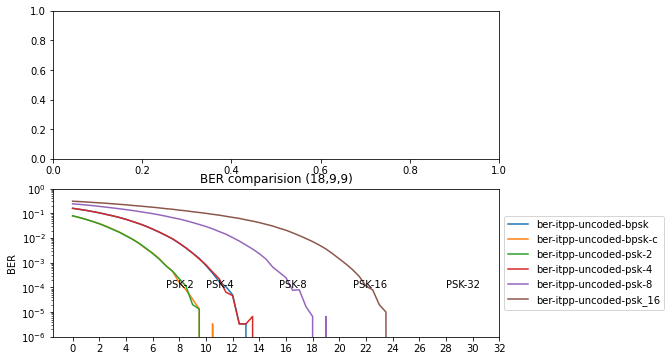

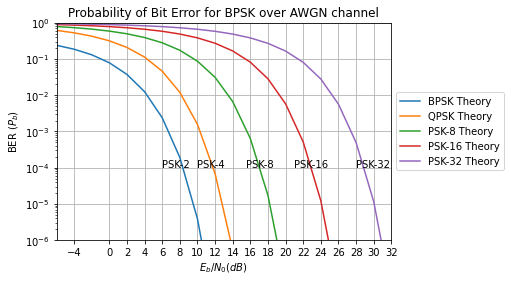

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_8,'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_16,'', label="ber-itpp-uncoded-psk_16") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.xticks(plot_x_axis)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_ylim(0.000001,1);

plt.text(7, 0.0001, 'PSK-2')
#plt.text(6.5, 0.001, 'QAM-8')
plt.text(10, 0.0001, 'PSK-4')
plt.text(15.5, 0.0001, 'PSK-8')
plt.text(21, 0.0001, 'PSK-16')
plt.text(28, 0.0001, 'PSK-32')

plt.show()
import numpy as np #for numerical computing
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
import math

EbN0dBs = np.arange(start=-6,stop = 33, step = 2)
BPSK_BER_theory = 0.5*erfc(np.sqrt(10**(EbN0dBs/10)))
M=4
#QAM_BER_theory = 2*(1-np.sqrt(1/M))*erfc(np.sqrt(10**(EbN0dBs/10)))
QAM_BER_theory = erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
QPSK_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
M=8
PSK_8_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_8_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=16
PSK_16_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))
QAM_16_BER_theory = 2*erfc(np.sqrt(math.log2(M)*3/(2*(M-1)))*np.sqrt(10**(EbN0dBs/10)))
M=32
PSK_32_BER_theory = erfc(math.sin(math.pi/M)*np.sqrt(10**(EbN0dBs/10)))

fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dBs,BPSK_BER_theory,marker='',linestyle='-',label='BPSK Theory')
ax.semilogy(EbN0dBs,QPSK_BER_theory,marker='',linestyle='-',label='QPSK Theory')
#ax.semilogy(EbN0dBs,QAM_BER_theory,marker='',linestyle='-',label='QAM Theory')
ax.semilogy(EbN0dBs,PSK_8_BER_theory,marker='',linestyle='-',label='PSK-8 Theory')
#ax.semilogy(EbN0dBs,QAM_8_BER_theory,marker='',linestyle='-',label='QAM-8 Theory')
ax.semilogy(EbN0dBs,PSK_16_BER_theory,marker='',linestyle='-',label='PSK-16 Theory')
#ax.semilogy(EbN0dBs,QAM_16_BER_theory,marker='',linestyle='-',label='QAM-16 Theory')
ax.semilogy(EbN0dBs,PSK_32_BER_theory,marker='',linestyle='-',label='PSK-32 Theory')
ax.set_xlabel('$E_b/N_0(dB)$');ax.set_ylabel('BER ($P_b$)')
ax.set_title('Probability of Bit Error for BPSK over AWGN channel')
ax.set_ylim(0.000001,1);
ax.grid(True);
ax.set_xlim(-6,30);
ax.grid(True);
ax.legend();
x = [-4,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
#x = [-4,0,4,8,12,16,20,24,28,32]
plt.xticks(x)
plt.text(6, 0.0001, 'PSK-2')
#plt.text(6.5, 0.001, 'QAM-8')
plt.text(10, 0.0001, 'PSK-4')
plt.text(15.5, 0.0001, 'PSK-8')
plt.text(21, 0.0001, 'PSK-16')
plt.text(28, 0.0001, 'PSK-32')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#ax.get_legend().remove()
plt.show()

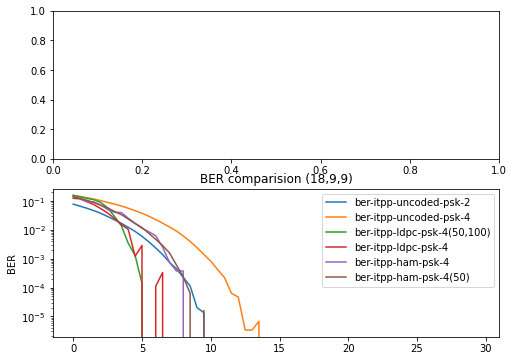

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
#ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
#ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_4,'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_bpsk,'', label="ber-itpp-ldpc-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_50_100_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_2,'', label="ber-itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ham_itpp_psk_4,'', label="ber-itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ham_50_itpp_psk_4,'', label="ber-itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

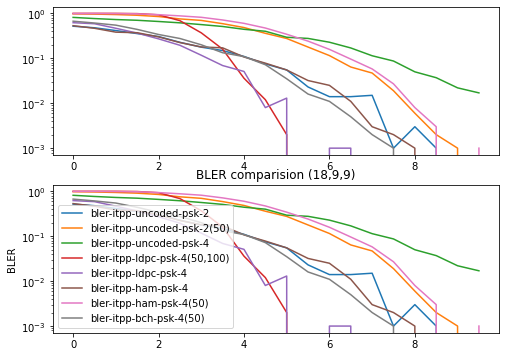

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs_db = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs[0:20],bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_uncoded_50_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2(50)") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="bler-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ldpc_itpp_psk_4,'', label="bler-itpp-ldpc-psk-4") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR
ax1.semilogy(snrs_db[0:20],bler_per_iter_bch_itpp_psk_4,'', label="bler-itpp-bch-psk-4(50)") # plot BER vs SNR

ax2.semilogy(snrs_db[0:20],bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_uncoded_50_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2(50)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="bler-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_itpp_psk_4,'', label="bler-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ham_itpp_psk_4,'', label="bler-itpp-ham-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ham_50_itpp_psk_4,'', label="bler-itpp-ham-psk-4(50)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_bch_itpp_psk_4,'', label="bler-itpp-bch-psk-4(50)") # plot BER vs SNR
ax2.set_ylabel('BLER')
ax2.set_title('BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

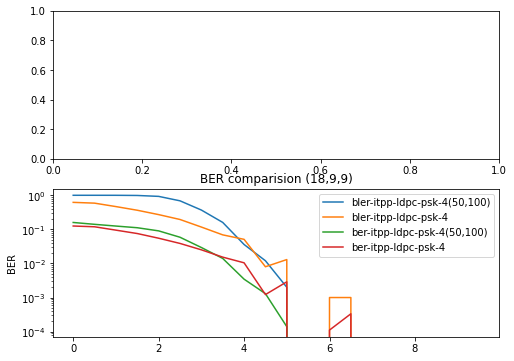

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="bler-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],bler_per_iter_ldpc_itpp_psk_4,'', label="bler-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_50_100_itpp_psk_4 ,'', label="ber-itpp-ldpc-psk-4(50,100)") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR

ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

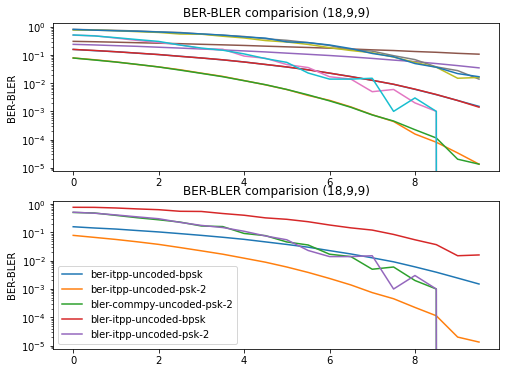

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_bpsk_c[0:20],'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk_2") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_4[0:20],'', label="ber-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_8[0:20],'', label="ber-itpp-uncoded-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_itpp_uncoded_psk_16[0:20],'', label="ber-itpp-uncoded-psk-16") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="bler-commpy-uncoded-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="bler-itpp-uncoded-psk-4") # plot BER vs SNR
ax1.set_ylabel('BER-BLER')
ax1.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax1.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax2.semilogy(snrs,ber_itpp_uncoded_bpsk[0:20],'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,ber_itpp_uncoded_psk_2[0:20],'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_qpsk[0:20],'', label="ber_unc_qpsk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_8psk[0:20],'', label="ber_unc_8psk") # plot BER vs SNR
#ax2.semilogy(snrs,ber_unc_16psk[0:20],'', label="ber_unc_16psk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2 ,'', label="bler-commpy-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-uncoded-qpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_bpsk,'', label="bler-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="bler-itpp-uncoded-psk-2") # plot BER vs SNR
#ax2.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-uncoded-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER-BLER')
ax2.set_title('BER-BLER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

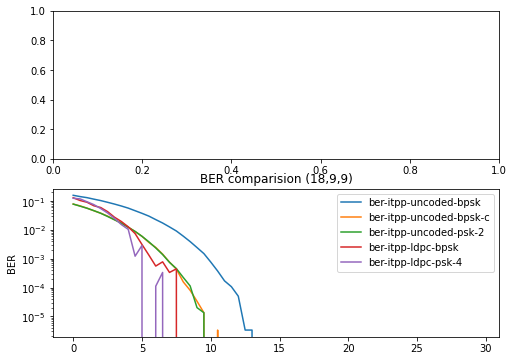

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END+20, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk,'', label="ber-itpp-uncoded-bpsk") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_bpsk_c,'', label="ber-itpp-uncoded-bpsk-c") # plot BER vs SNR
ax2.semilogy(snrs_db,ber_itpp_uncoded_psk_2,'', label="ber-itpp-uncoded-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_bpsk,'', label="ber-itpp-ldpc-bpsk") # plot BER vs SNR
#ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_2,'', label="ber-itpp-ldpc-psk-2") # plot BER vs SNR
ax2.semilogy(snrs_db[0:20],ber_per_iter_ldpc_itpp_psk_4,'', label="ber-itpp-ldpc-psk-4") # plot BER vs SNR
ax2.set_ylabel('BER')
ax2.set_title('BER comparision ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.annotate('',
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

No Bit Errors :)
No Bit Errors :)
No Bit Errors :)


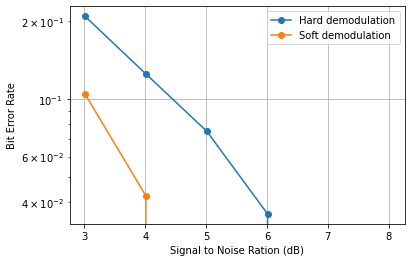

In [71]:
#https://github.com/veeresht/CommPy/blob/master/commpy/examples/conv_encode_decode.py
# Authors: CommPy contributors
# License: BSD 3-Clause

from __future__ import division, print_function  # Python 2 compatibility

import math

import matplotlib.pyplot as plt
import numpy as np

import commpy.channelcoding.convcode as cc
import commpy.channels as chan
import commpy.links as lk
import commpy.modulation as mod
import commpy.utilities as util

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D+D^2]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(2, ndmin=1)

# Generator matrix
g_matrix = np.array((0o5, 0o7), ndmin=2)

# Create trellis data structure
trellis1 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 1: G(D) = [1+D^2, 1+D^2+D^3]
# Standard code with rate 1/2
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array(3, ndmin=1)

# Generator matrix (1+D^2+D^3 <-> 13 or 0o15)
g_matrix = np.array((0o5, 0o15), ndmin=2)

# Create trellis data structure
trellis2 = cc.Trellis(memory, g_matrix)

# =============================================================================
# Convolutional Code 2: G(D) = [[1, 0, 0], [0, 1, 1+D]]; F(D) = [[D, D], [1+D, 1]]
# RSC with rate 2/3
# =============================================================================

# Number of delay elements in the convolutional encoder
memory = np.array((1, 1))

# Generator matrix & feedback matrix
g_matrix = np.array(((1, 0, 0), (0, 1, 3)))
feedback = np.array(((2, 2), (3, 1)))

# Create trellis data structure
trellis3 = cc.Trellis(memory, g_matrix, feedback, 'rsc')

# =============================================================================
# Basic example using homemade counting and hard decoding
# =============================================================================

# Traceback depth of the decoder
tb_depth = None  # Default value is 5 times the number or memories

for trellis in (trellis1, trellis2, trellis3):
    for i in range(10):
        # Generate random message bits to be encoded
        message_bits = np.random.randint(0, 2, 1000)

        # Encode message bits
        coded_bits = cc.conv_encode(message_bits, trellis)

        # Introduce bit errors (channel)
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 0
        coded_bits[np.random.randint(0, 1000)] = 1
        coded_bits[np.random.randint(0, 1000)] = 1

        # Decode the received bits
        decoded_bits = cc.viterbi_decode(coded_bits.astype(float), trellis, tb_depth)

        num_bit_errors = util.hamming_dist(message_bits, decoded_bits[:len(message_bits)])

        if num_bit_errors != 0:
            print(num_bit_errors, "Bit Errors found!")
        elif i == 9:
            print("No Bit Errors :)")

# ==================================================================================================
# Complete example using Commpy features and compare hard and soft demodulation. Example with code 1
# ==================================================================================================

# Modem : QPSK
modem = mod.QAMModem(4)

# AWGN channel
channels = chan.SISOFlatChannel(None, (1 + 0j, 0j))

# SNR range to test
SNRs = np.arange(0, 6) + 10 * math.log10(modem.num_bits_symbol)


# Modulation function
def modulate(bits):
    return modem.modulate(cc.conv_encode(bits, trellis1, 'cont'))


# Receiver function (no process required as there are no fading)
def receiver_hard(y, h, constellation, noise_var):
    return modem.demodulate(y, 'hard')


# Receiver function (no process required as there are no fading)
def receiver_soft(y, h, constellation, noise_var):
    return modem.demodulate(y, 'soft', noise_var)


# Decoder function
def decoder_hard(msg):
    return cc.viterbi_decode(msg, trellis1)


# Decoder function
def decoder_soft(msg):
    return cc.viterbi_decode(msg, trellis1, decoding_type='soft')


# Build model from parameters
code_rate = trellis1.k / trellis1.n
model_hard = lk.LinkModel(modulate, channels, receiver_hard,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_hard, code_rate)
model_soft = lk.LinkModel(modulate, channels, receiver_soft,
                          modem.num_bits_symbol, modem.constellation, modem.Es,
                          decoder_soft, code_rate)

# Test
BERs_hard = model_hard.link_performance(SNRs, 10000, 600, 5000, code_rate)
BERs_soft = model_soft.link_performance(SNRs, 10000, 600, 5000, code_rate)
plt.semilogy(SNRs, BERs_hard, 'o-', SNRs, BERs_soft, 'o-')
plt.grid()
plt.xlabel('Signal to Noise Ration (dB)')
plt.ylabel('Bit Error Rate')
plt.legend(('Hard demodulation', 'Soft demodulation'))
plt.show()

In [72]:
print (bler_per_iter_ldpc_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_2=",  bler_per_iter_uncoded_commpy_psk_2, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_2=",  bler_per_iter_uncoded_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_4=",  bler_per_iter_uncoded_commpy_psk_4, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_4=",  bler_per_iter_uncoded_itpp_psk_4)
print ("bler_per_iter_uncoded_itpp_psk_8=",  bler_per_iter_uncoded_itpp_psk_8)

[0.084 0.063 0.03  0.019 0.015 0.    0.002 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
bler_per_iter_uncoded_commpy_psk_2=, [0.508 0.485 0.401 0.331 0.28  0.232 0.169 0.161 0.092 0.077 0.046 0.036
 0.017 0.014 0.005 0.006 0.002 0.001 0.    0.   ]
bler_per_iter_uncoded_itpp_psk_2= [0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
bler_per_iter_uncoded_commpy_psk_4=, [0.817 0.784 0.755 0.716 0.666 0.633 0.558 0.507 0.457 0.379 0.334 0.276
 0.219 0.153 0.138 0.095 0.069 0.038 0.028 0.014]
bler_per_iter_uncoded_itpp_psk_4= [0.814 0.767 0.729 0.702 0.66  0.616 0.563 0.511 0.442 0.4   0.294 0.277
 0.228 0.17  0.114 0.087 0.05  0.037 0.022 0.017]
bler_per_iter_uncoded_itpp_psk_8= [0.921 0.917 0.912 0.867 0.86  0.857 0.826 0.808 0.77  0.737 0.704 0.657
 0.608 0.6   0.547 0.487 0.426 0.361 0.323 0.293]


In [73]:
print (bler_per_iter_ldpc_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_2=",  bler_per_iter_uncoded_commpy_psk_2, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_2=",  bler_per_iter_uncoded_itpp_psk_2)
print ("bler_per_iter_uncoded_commpy_psk_4=",  bler_per_iter_uncoded_commpy_psk_4, sep=", ")
print ("bler_per_iter_uncoded_itpp_psk_4=",  bler_per_iter_uncoded_itpp_psk_4)
print ("bler_per_iter_uncoded_itpp_psk_8=",  bler_per_iter_uncoded_itpp_psk_8)
print ("bler_per_iter_uncoded_commpy_psk_8=",  bler_per_iter_uncoded_commpy_psk_8)

[0.084 0.063 0.03  0.019 0.015 0.    0.002 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
bler_per_iter_uncoded_commpy_psk_2=, [0.508 0.485 0.401 0.331 0.28  0.232 0.169 0.161 0.092 0.077 0.046 0.036
 0.017 0.014 0.005 0.006 0.002 0.001 0.    0.   ]
bler_per_iter_uncoded_itpp_psk_2= [0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
bler_per_iter_uncoded_commpy_psk_4=, [0.817 0.784 0.755 0.716 0.666 0.633 0.558 0.507 0.457 0.379 0.334 0.276
 0.219 0.153 0.138 0.095 0.069 0.038 0.028 0.014]
bler_per_iter_uncoded_itpp_psk_4= [0.814 0.767 0.729 0.702 0.66  0.616 0.563 0.511 0.442 0.4   0.294 0.277
 0.228 0.17  0.114 0.087 0.05  0.037 0.022 0.017]
bler_per_iter_uncoded_itpp_psk_8= [0.921 0.917 0.912 0.867 0.86  0.857 0.826 0.808 0.77  0.737 0.704 0.657
 0.608 0.6   0.547 0.487 0.426 0.361 0.323 0.293]
bler_per_iter_uncoded_commpy_psk_8= [0.923 0.912 0.891 0.888 0.874 0.851 0.804 0.779 0.75

In [74]:
print ("bler_per_iter_ham_itpp_bpsk", bler_per_iter_ham_itpp_bpsk)
print ("bler_per_iter_ham_itpp_psk_4", bler_per_iter_ham_itpp_psk_4)

bler_per_iter_ham_itpp_bpsk [0.537 0.402 0.397 0.362 0.293 0.239 0.18  0.149 0.12  0.074 0.056 0.034
 0.016 0.014 0.006 0.003 0.003 0.001 0.    0.   ]
bler_per_iter_ham_itpp_psk_4 [0.532 0.466 0.382 0.371 0.3   0.224 0.179 0.171 0.107 0.078 0.055 0.032
 0.025 0.011 0.003 0.002 0.001 0.    0.    0.   ]


In [75]:
print (bler_per_iter_ldpc_50_100_itpp_psk_4)
print (bler_per_iter_uncoded_100_commpy_psk_4)
print (bler_per_iter_uncoded_100_itpp_psk_4)

print (ber_per_iter_ldpc_50_100_itpp_psk_4)


[1.    1.    0.999 0.988 0.929 0.688 0.369 0.16  0.036 0.012 0.002 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[1.    1.    1.    1.    1.    1.    1.    0.999 0.999 0.986 0.978 0.947
 0.903 0.828 0.719 0.577 0.444 0.326 0.204 0.148]
[1.    1.    1.    1.    1.    1.    1.    0.998 0.999 0.992 0.986 0.955
 0.904 0.834 0.69  0.606 0.464 0.305 0.209 0.138]
[1.5934e-01 1.4056e-01 1.2508e-01 1.1166e-01 9.0340e-02 5.8760e-02
 2.9380e-02 1.4040e-02 3.4600e-03 1.3000e-03 1.4000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00]


In [76]:
# File:   hamming.py
# Brief:  Simulates a Hamming coded radio link over AWGN channel
# Author: Vidit Saxena
#
# Usage:  import hamming
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#import itpp

def block_error_ratio_hamming_awgn(snr_db, block_size):
    
    mapping_k_m = {4: 3} # Mapping from k (block size) to m. m = 3 implies (7,4) code
    m = mapping_k_m[block_size]
     
    '''Hamming encoder and decoder instance'''
    hamm = itpp.comm.Hamming_Code(m)
    n = pow(2,m) - 1 # channel use
    rate = float(block_size)/float(n)
    
    '''Generate random bits'''
    nrof_bits = 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    
    '''Encode the bits'''
    encoded_bits = hamm.encode(source_bits)
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(encoded_bits)
    
    '''Add the effect of channel to the signal'''
    #rate = 1.0 # VIJAYA_MODIFY
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    print ("block_error_ratio_hamming_awgn:noise_var:", noise_variance, " ", snr_db)
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Decode the received bits'''
    decoded_bits = hamm.decode(demodulated_bits) 
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, decoded_bits)
    return blerc.get_errorrate()

In [77]:
# File:   uncoded.py
# Brief:  Simulates uncoded link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import uncoded
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------



def block_error_ratio_uncoded_awgn(snr_db, block_size):
    '''Generate random bits'''
    nrof_bits = 3 * 10000 * block_size
    source_bits = itpp.randb(nrof_bits)
    rate = 1.0
    
    '''Modulate the bits'''
    modulator_ = itpp.comm.modulator_2d()
    constellation = itpp.cvec('-1+0i, 1+0i')
    symbols = itpp.ivec('0, 1')
    modulator_.set(constellation, symbols)
    tx_signal = modulator_.modulate_bits(source_bits)
    
    '''Add the effect of channel to the signal'''
    noise_variance = 1.0 / (rate * pow(10, 0.1 * snr_db))
    print ("block_error_ratio_uncoded_awgn:noise_var:",noise_variance, " ", snr_db)
    noise = itpp.randn_c(tx_signal.length())
    noise *= itpp.math.sqrt(noise_variance)
    rx_signal = tx_signal + noise
    
    '''Demodulate the signal'''
    demodulated_bits = modulator_.demodulate_bits(rx_signal)
    
    '''Calculate the block error ratio'''
    blerc = itpp.comm.BLERC(block_size)
    blerc.count(source_bits, demodulated_bits)
    return blerc.get_errorrate()

In [78]:
# File:   autoencoder.py
# Brief:  Neural network autoencoded radio link over AWGN channel 
# Author: Vidit Saxena
#
# Usage:  import autoencoder
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

import tensorflow as tf
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

def block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use, batch_size, nrof_steps):
    
    print('block_size %d'%(block_size))
    print('channel_use %d'%(channel_use))
    
    rate = float(block_size)/float(channel_use)
    print('rate %0.2f'%(rate))
    
    '''The input is one-hot encoded vector for each codeword'''
    alphabet_size = pow(2, block_size)
    alphabet = np.eye(alphabet_size, dtype = 'float32') # One-hot encoded values
    
    '''Repeat the alphabet to create training and test datasets'''
    train_dataset = np.transpose(np.tile(alphabet, int(batch_size)))
    test_dataset = np.transpose(np.tile(alphabet, int(batch_size * 1000)))
    
    print('--Setting up autoencoder graph--')
    input, output, noise_std_dev, h_norm = _implement_autoencoder(alphabet_size, channel_use)
    
    print( '--Setting up training scheme--')
    train_step = _implement_training(output, input)
    
    print('--Setting up accuracy--')
    accuracy = _implement_accuracy(output, input)

    print('--Starting the tensorflow session--')
    sess = _setup_interactive_tf_session()
    _init_and_start_tf_session(sess)
    
    print('--Training the autoencoder over awgn channel--')
    _train(train_step, input, noise_std_dev, nrof_steps, train_dataset, snrs_db, rate, accuracy)
    
    print('--Evaluating autoencoder performance--')
    bler = _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy)
    
    print('--Closing the session--')
    _close_tf_session(sess)
    
    return bler
    
def _setup_tf_session():
    return tf.Session()

def _setup_interactive_tf_session():
    return tf.compat.v1.InteractiveSession()

def _init_and_start_tf_session():
    init = tf.compat.v1.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess

def _init_and_start_tf_session(sess):
    sess.run(tf.compat.v1.global_variables_initializer())
    
def _close_tf_session(sess):
    sess.close
    
def _weight_variable(shape):
    initial = tf.random.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def _bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

def _implement_autoencoder(input_dimension, encoder_dimension):
    input = tf.compat.v1.placeholder(tf.float32, [None, input_dimension])
    
    '''Densely connected encoder layer'''
    W_enc1 = _weight_variable([input_dimension, input_dimension])
    b_enc1 = _bias_variable([input_dimension])
    
    h_enc1 = tf.nn.relu(tf.matmul(input, W_enc1) + b_enc1)
    
    '''Densely connected encoder layer'''
    W_enc2 = _weight_variable([input_dimension, encoder_dimension])
    b_enc2 = _bias_variable([encoder_dimension])
    
    h_enc2 = tf.matmul(h_enc1, W_enc2) + b_enc2
    
    '''Normalization layer'''
    normalization_factor = tf.math.reciprocal(tf.sqrt(tf.reduce_sum(tf.square(h_enc2), 1))) * np.sqrt(encoder_dimension)
    h_norm = tf.multiply(tf.tile(tf.expand_dims(normalization_factor, 1), [1, encoder_dimension]), h_enc2)

    '''AWGN noise layer'''
    noise_std_dev = tf.compat.v1.placeholder(tf.float32)
    channel = tf.random.normal(tf.shape(h_norm), stddev=noise_std_dev)
    h_noisy = tf.add(h_norm, channel)
    
    '''Densely connected decoder layer'''
    W_dec1 = _weight_variable([encoder_dimension, input_dimension])
    b_dec1 = _bias_variable([input_dimension])
    
    h_dec1 = tf.nn.relu(tf.matmul(h_noisy, W_dec1) + b_dec1)
        
    '''Output layer'''
    W_out = _weight_variable([input_dimension, input_dimension])
    b_out = _bias_variable([input_dimension])
     
    output = tf.nn.softmax(tf.matmul(h_dec1, W_out) + b_out)
    
    return (input, output, noise_std_dev, h_norm)
    
def _implement_training(output, input):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output, labels = input))
    
#     train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(cross_entropy) 
    train_step = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    return train_step

def _implement_accuracy(output, input):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(input, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def _train(train_step, input, noise_std_dev, nrof_steps, training_dataset, snrs_db, rate, accuracy):
    print('--Training--')
    print('number of steps %d'%(nrof_steps))
    snr = max(snrs_db)
    snrs_rev = snrs_db[::-1]
    for snr in snrs_rev[0:1]: # Train with higher SNRs first
        print('training snr %0.2f db'%(snr))
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        #noise = np.sqrt(1.0 / ( pow(10, 0.1 * snr))) # VIJAYA_MODIFY
        print ("_train:noise_var:", noise, " ", snr)

        for i in range(int(nrof_steps)):
            batch = training_dataset
            np.random.shuffle(batch)
            if (i + 1) % (nrof_steps/10) == 0: # i = 0 is the first step
                print('training step %d'%(i + 1))
            train_step.run(feed_dict={input: batch, noise_std_dev: noise})
        print('training accuracy %0.4f'%(accuracy.eval(feed_dict={input: batch, noise_std_dev: noise})))

def _evaluate(input, noise_std_dev, test_dataset, snrs_db, rate, accuracy):
    print('--Evaluating NN performance on test dataset--')
    bler = []
    for snr in snrs_db:
        noise = np.sqrt(1.0 / (2 * rate * pow(10, 0.1 * snr)))
        print ("_evaluate:noise_var:", noise, " ", snr)
        acc = accuracy.eval(feed_dict={input: test_dataset, noise_std_dev: noise})
        bler.append(1.0 - acc)
    return bler

Instructions for updating:
non-resource variables are not supported in the long term


-------Evaluating BLER for Uncoded (4,4) over AWGN-------
block_error_ratio_uncoded_awgn:noise_var: 2.5118864315095806   -4
block_error_ratio_uncoded_awgn:noise_var: 1.9952623149688797   -3
block_error_ratio_uncoded_awgn:noise_var: 1.5848931924611134   -2
block_error_ratio_uncoded_awgn:noise_var: 1.2589254117941673   -1
block_error_ratio_uncoded_awgn:noise_var: 1.0   0
block_error_ratio_uncoded_awgn:noise_var: 0.7943282347242815   1
block_error_ratio_uncoded_awgn:noise_var: 0.6309573444801932   2
block_error_ratio_uncoded_awgn:noise_var: 0.5011872336272722   3
block_error_ratio_uncoded_awgn:noise_var: 0.39810717055349726   4
block_error_ratio_uncoded_awgn:noise_var: 0.31622776601683794   5
block_error_ratio_uncoded_awgn:noise_var: 0.25118864315095796   6
block_error_ratio_uncoded_awgn:noise_var: 0.19952623149688792   7
block_error_ratio_uncoded_awgn:noise_var: 0.15848931924611132   8
-------Evaluating BLER for Hamming (7,4) over AWGN-------
block_error_ratio_hamming_awgn:noise_var: 4.3

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


training step 5000
training step 10000
training step 15000
training step 20000
training step 25000
training step 30000
training step 35000
training step 40000
training step 45000
training step 50000
training accuracy 1.0000
--Evaluating autoencoder performance--
--Evaluating NN performance on test dataset--
_evaluate:noise_var: 1.1206887238456493   -4
_evaluate:noise_var: 0.9988148764833451   -3
_evaluate:noise_var: 0.8901946956877224   -2
_evaluate:noise_var: 0.7933868576533668   -1
_evaluate:noise_var: 0.7071067811865476   0
_evaluate:noise_var: 0.6302095820932436   1
_evaluate:noise_var: 0.5616748812614791   2
_evaluate:noise_var: 0.5005932648504533   3
_evaluate:noise_var: 0.4461542169214011   4
_evaluate:noise_var: 0.3976353643835253   5
_evaluate:noise_var: 0.3543928915419707   6
_evaluate:noise_var: 0.3158529970547121   7
_evaluate:noise_var: 0.2815042799373673   8
--Closing the session--
-------Plotting results-------
-------Evaluating BLER for Uncoded BPSK (8,8) over AWGN-----

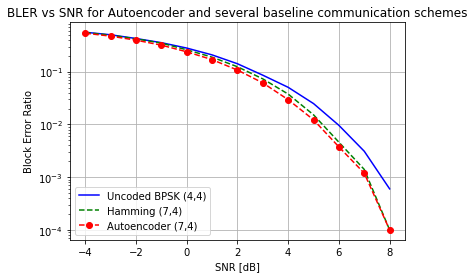

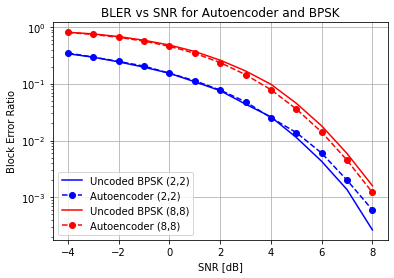

In [79]:
# File:   radio_autoencoder.py
# Brief:  Simulates a radio link over AWGN channel for Uncoded, Hamming 
#         coded and Neural network autoencoded radio links.
#         Reproduces the results obtained in 
#         "An Introduction to Deep Learning for the Physical Layer",
#         Timothy J. O'Shea, Jakob Hoydis
# Author: Vidit Saxena
#
# Usage:  python radio_autoencoder.py
#
# -------------------------------------------------------------------------
#
# Copyright (C) 2016 CC0 1.0 Universal (CC0 1.0) 
#
# The person who associated a work with this deed has dedicated the work to
# the public domain by waiving all of his or her rights to the work 
# worldwide under copyright law, including all related and neighboring 
# rights, to the extent allowed by law.
#
# You can copy, modify, distribute and perform the work, even for commercial 
# purposes, all without asking permission.
#
# See the complete legal text at 
# <https://creativecommons.org/publicdomain/zero/1.0/legalcode>
#
# -------------------------------------------------------------------------

#from src import uncoded, hamming
#from src import autoencoder

from matplotlib import pyplot as plt

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) 
                 curves for standard channel coding using Hamming codes, 
                 and for 'learnt' optimal representation that are obtained 
                 by training a neural network based autoencoder. Additive 
                 White Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db):
    
    channel_use = {4: 7} # Mapping to get length of Hamming codeblock from block length 
        
    '''BLER for uncoded BPSK over AWGN channel'''
    print('-------Evaluating BLER for Uncoded (%d,%d) over AWGN-------'%(block_size, block_size))
    bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
     
    '''BLER for Hamming coded bits over AWGN channel'''
    print('-------Evaluating BLER for Hamming (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    bler_hamming = [block_error_ratio_hamming_awgn(snr, block_size) for snr in snrs_db]
    
    '''BLER for Autoencoder coded bits over AWGN channel'''
    print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(channel_use[block_size], block_size))
    batch_size = int(20/block_size)
    nrof_steps = int(200000/block_size)
    bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, channel_use[block_size], batch_size, nrof_steps)
    
    print('-------Plotting results-------')
    plt.figure()
    plt.grid(True)
    plt.semilogy(snrs_db, bler_unc, ls = '-', c = 'b')
    plt.semilogy(snrs_db, bler_hamming, ls = '--', c = 'g')
    plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = 'r', marker = 'o')
    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(['Uncoded BPSK (%d,%d)'%(block_size, block_size), 
                'Hamming (%d,%d)'%(channel_use[block_size], block_size),
                'Autoencoder (%d,%d)'%(channel_use[block_size], block_size)],
               loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and several baseline communication schemes')
    
    print (bler_unc)
    print(bler_hamming)
    print (bler_autoenc)
    return (bler_hamming, bler_autoenc)

''' Function:    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)
    Description: Block error ratio (BLER) vs Signal to Noise Ratio (SNR) curves 
                 for uncoded transmission, and for 'learnt' optimal 
                 representations of the transmitted bits that are obtained by 
                 training a neural network based autoencoder. Additive White 
                 Gaussian Noise (AWGN) channel is assumed. 
'''  
def _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db):
    
    plt.figure()
    plt.grid(True)
    legend_strings = []
    colors = iter(list(['b', 'r', 'g', 'b', 'm']))
    for block_size in block_sizes:
        '''BLER for uncoded bits over AWGN channel'''
        print('-------Evaluating BLER for Uncoded BPSK (%d,%d) over AWGN-------' %(block_size, block_size))
        bler_unc = [block_error_ratio_uncoded_awgn(snr, block_size) for snr in snrs_db]
    
        '''BLER for Autoencoder coded  bits over AWGN channel'''
        print('-------Evaluating BLER for Autoencoder (%d,%d) over AWGN-------' %(block_size, block_size))
        batch_size = 10/block_size
        nrof_steps = 100000/block_size
        bler_autoenc = block_error_ratio_autoencoder_awgn(snrs_db, block_size, block_size, batch_size, nrof_steps)
        
        print('-------Plotting results-------')
        color = next(colors) 
        plt.semilogy(snrs_db, bler_unc, ls = '-', c = color)
        plt.semilogy(snrs_db, bler_autoenc, ls = '--', c = color, marker = 'o')
        
        legend_strings.append('Uncoded BPSK (%d,%d)'%(block_size, block_size))
        legend_strings.append('Autoencoder (%d,%d)'%(block_size, block_size))

    plt.xlabel('SNR [dB]')
    plt.ylabel('Block Error Ratio')
    plt.legend(legend_strings, loc = 'lower left')
    plt.title('BLER vs SNR for Autoencoder and BPSK')
    
if __name__ == '__main__':
    snrs_db = range(-4, 9)
    
    '''BLER for block size 4 with Autoencoder and Hamming'''
    block_size = 4
    channel_use = 7
    _bler_vs_snr_hamming_autoenc(block_size, channel_use, snrs_db)

    '''BLER for block sizes 2 and 8 with uncoded and Autoencoder'''
    block_sizes = [2, 8]
    _bler_vs_snr_uncoded_autoenc(block_sizes, snrs_db)
    
    plt.show()

In [80]:
print ("bpsk")
print(ber_itpp_uncoded_bpsk)
print(ber_per_iter_uncoded_itpp_bpsk)
print(ber_per_iter_ham_itpp_bpsk)
print(ber_per_iter_ldpc_itpp_bpsk)

print ("psk-2")
print(ber_itpp_uncoded_bpsk_c)
print(ber_itpp_uncoded_psk_2)
print(ber_per_iter_uncoded_itpp_psk_2)
print(ber_per_iter_uncoded_50_itpp_psk_2)
print(ber_per_iter_uncoded_100_itpp_psk_2)
print(ber_per_iter_uncoded_commpy_psk_2)
print(ber_per_iter_uncoded_50_commpy_psk_2)
print(ber_per_iter_uncoded_100_commpy_psk_2)
print(ber_per_iter_ham_itpp_psk_2)
print(ber_per_iter_ham_50_itpp_psk_2)
print(ber_per_iter_ldpc_itpp_psk_2)

print ("psk-4")
print(ber_itpp_uncoded_psk_4)
print(ber_per_iter_uncoded_itpp_psk_4)
print(ber_per_iter_uncoded_50_itpp_psk_4)
print(ber_per_iter_uncoded_100_itpp_psk_4)
print(ber_per_iter_uncoded_commpy_psk_4)
print(ber_per_iter_uncoded_50_commpy_psk_4)
print(ber_per_iter_uncoded_100_commpy_psk_4)
print(ber_per_iter_ham_itpp_psk_4)
print(ber_per_iter_ham_50_itpp_psk_4)
print(ber_per_iter_ldpc_50_100_itpp_psk_4)
print(ber_per_iter_ldpc_itpp_psk_4)

print ("psk-8")
print(ber_itpp_uncoded_psk_8)
print(ber_per_iter_uncoded_itpp_psk_8)
print(ber_per_iter_uncoded_commpy_psk_8)


bpsk
[0.15892333333333333, 0.14329, 0.13157333333333332, 0.11666666666666667, 0.10406666666666667, 0.09071, 0.07874333333333333, 0.06747333333333333, 0.05697666666666667, 0.046283333333333336, 0.0376, 0.03008, 0.022746666666666665, 0.01733, 0.012663333333333334, 0.009146666666666668, 0.006063333333333333, 0.003926666666666667, 0.002436666666666667, 0.0015033333333333333, 0.0007633333333333333, 0.0003733333333333333, 0.00017, 0.00010666666666666667, 5e-05, 3.3333333333333333e-06, 3.3333333333333333e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.15777778 0.13966667 0.12955556 0.11833333 0.10722222 0.08844444
 0.08277778 0.06888889 0.05388889 0.045      0.03611111 0.03033333
 0.02188889 0.018      0.01377778 0.00955556 0.00622222 0.00411111
 0.00166667 0.00177778]
[0.143375 0.10575  0.10325  0.091    0.073375 0.0595   0.044    0.03375
 0.025625 0.01675  0.01275  0.

In [81]:
print ("bpsk")
print(bler_per_iter_uncoded_itpp_bpsk)
print(bler_per_iter_ham_itpp_bpsk)
print(bler_per_iter_ldpc_itpp_bpsk)

print("")
print ("psk-2")
print(bler_per_iter_uncoded_itpp_psk_2)
print(bler_per_iter_uncoded_50_itpp_psk_2)
print(bler_per_iter_uncoded_100_itpp_psk_2)
print(bler_per_iter_uncoded_commpy_psk_2)
print(bler_per_iter_uncoded_50_commpy_psk_2)
print(bler_per_iter_uncoded_100_commpy_psk_2)
print(bler_per_iter_ham_itpp_psk_2)
print(bler_per_iter_ham_50_itpp_psk_2)
print(bler_per_iter_ldpc_itpp_psk_2)


print("")
print ("psk-4")
print(bler_per_iter_uncoded_itpp_psk_4)
print(bler_per_iter_uncoded_50_itpp_psk_4)
print(bler_per_iter_uncoded_100_itpp_psk_4)
print(bler_per_iter_uncoded_commpy_psk_4)
print(bler_per_iter_uncoded_50_commpy_psk_4)
print(bler_per_iter_uncoded_100_commpy_psk_4)
print(bler_per_iter_ham_itpp_psk_4)
print(bler_per_iter_ham_50_itpp_psk_4)
print(bler_per_iter_ldpc_50_100_itpp_psk_4)
print(bler_per_iter_ldpc_itpp_psk_4)
print("")
print ("psk-8")
print(bler_per_iter_uncoded_itpp_psk_8)
print(bler_per_iter_uncoded_commpy_psk_8)


bpsk
[0.774 0.769 0.731 0.678 0.636 0.559 0.551 0.466 0.405 0.327 0.291 0.239
 0.183 0.145 0.121 0.085 0.055 0.037 0.015 0.016]
[0.537 0.402 0.397 0.362 0.293 0.239 0.18  0.149 0.12  0.074 0.056 0.034
 0.016 0.014 0.006 0.003 0.003 0.001 0.    0.   ]
[0.643 0.553 0.455 0.347 0.305 0.217 0.14  0.1   0.069 0.042 0.02  0.008
 0.003 0.003 0.002 0.003 0.    0.    0.    0.   ]

psk-2
[0.518 0.478 0.415 0.355 0.305 0.227 0.177 0.149 0.11  0.075 0.055 0.023
 0.014 0.014 0.015 0.001 0.003 0.001 0.    0.   ]
[0.978 0.964 0.941 0.908 0.85  0.753 0.697 0.59  0.484 0.36  0.276 0.178
 0.115 0.064 0.047 0.019 0.006 0.002 0.001 0.   ]
[0.999 0.999 0.997 0.992 0.976 0.945 0.904 0.824 0.703 0.609 0.429 0.329
 0.225 0.131 0.079 0.042 0.013 0.005 0.003 0.   ]
[0.508 0.485 0.401 0.331 0.28  0.232 0.169 0.161 0.092 0.077 0.046 0.036
 0.017 0.014 0.005 0.006 0.002 0.001 0.    0.   ]
[0.984 0.977 0.951 0.902 0.852 0.758 0.69  0.573 0.445 0.334 0.25  0.169
 0.105 0.062 0.033 0.012 0.008 0.002 0.001 0.002]
[1. 